# Mini Project - IronKaggle - Version Delivered

In this notebook, we load and clean the dataset, then explore different ML models to predict future sales.

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

## Import dataset

In [2]:
# load dataset
file_path = 'sales.csv'
sales_data = pd.read_csv(file_path)
print(sales_data.info())
sales_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           640840 non-null  int64 
 1   store_ID             640840 non-null  int64 
 2   day_of_week          640840 non-null  int64 
 3   date                 640840 non-null  object
 4   nb_customers_on_day  640840 non-null  int64 
 5   open                 640840 non-null  int64 
 6   promotion            640840 non-null  int64 
 7   state_holiday        640840 non-null  object
 8   school_holiday       640840 non-null  int64 
 9   sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB
None


,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


## Data Cleaning

In [3]:
# check for missing value
sales_data_cleaned = sales_data.copy()
print(sales_data_cleaned.isna().sum())

Unnamed: 0             0
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64


In [4]:
# Convert 'date' column to datetime
sales_data_cleaned['date'] = pd.to_datetime(sales_data_cleaned['date'])

# One-hot encoding of 'state_holiday' and convert them to int32
sales_data_cleaned = pd.get_dummies(sales_data_cleaned, columns=['state_holiday'], drop_first=True)
boolean_columns = ['state_holiday_a', 'state_holiday_b', 'state_holiday_c']
sales_data_cleaned[boolean_columns] = sales_data_cleaned[boolean_columns].astype(int)

# Convert bool columns to int
sales_data_cleaned = sales_data_cleaned.astype({col: 'int' for col in sales_data_cleaned.select_dtypes(include='bool').columns})

# Drop 'Unnamed: 0' column
sales_data_cleaned = sales_data_cleaned.drop(columns=['Unnamed: 0'])

sales_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   store_ID             640840 non-null  int64         
 1   day_of_week          640840 non-null  int64         
 2   date                 640840 non-null  datetime64[ns]
 3   nb_customers_on_day  640840 non-null  int64         
 4   open                 640840 non-null  int64         
 5   promotion            640840 non-null  int64         
 6   school_holiday       640840 non-null  int64         
 7   sales                640840 non-null  int64         
 8   state_holiday_a      640840 non-null  int32         
 9   state_holiday_b      640840 non-null  int32         
 10  state_holiday_c      640840 non-null  int32         
dtypes: datetime64[ns](1), int32(3), int64(7)
memory usage: 46.4 MB


## Feature Engineering

In [5]:
# Extract additional features from the 'date' column as int32 and drop date column
sales_data_cleaned['year'] = sales_data_cleaned['date'].dt.year.astype('int32')
sales_data_cleaned['month'] = sales_data_cleaned['date'].dt.month.astype('int32')
sales_data_cleaned['day'] = sales_data_cleaned['date'].dt.day.astype('int32')
sales_data_cleaned['week_of_year'] = sales_data_cleaned['date'].dt.isocalendar().week.astype('int32')
sales_data_cleaned.drop('date', axis=1, inplace=True)
sales_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   store_ID             640840 non-null  int64
 1   day_of_week          640840 non-null  int64
 2   nb_customers_on_day  640840 non-null  int64
 3   open                 640840 non-null  int64
 4   promotion            640840 non-null  int64
 5   school_holiday       640840 non-null  int64
 6   sales                640840 non-null  int64
 7   state_holiday_a      640840 non-null  int32
 8   state_holiday_b      640840 non-null  int32
 9   state_holiday_c      640840 non-null  int32
 10  year                 640840 non-null  int32
 11  month                640840 non-null  int32
 12  day                  640840 non-null  int32
 13  week_of_year         640840 non-null  int32
dtypes: int32(7), int64(7)
memory usage: 51.3 MB


## Check dataset collinearity and balance

In [6]:
# Let's check features collinearity

# Plot correlation matrix using Plotly
def print_correlation_matrix(correlation_matrix):
    """
    Plot correlatoin matrix using Plotly
    """
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    masked_correlation = correlation_matrix.mask(mask)

    fig = go.Figure(
        data=go.Heatmap(
            z=masked_correlation.values,
            x=correlation_matrix.columns,
            y=correlation_matrix.columns,
            colorscale='Viridis',
            text=correlation_matrix.values,
            texttemplate="%{text:.2f}",
            hoverinfo='z'
        )
    )

    # Adding titles and labels
    fig.update_layout(
        title='Correlation Matrix',
        xaxis_nticks=36,
        width=800, height=800,
        yaxis=dict(tickmode='linear'),
        xaxis=dict(tickangle=90),
        autosize=False)

    # Display the interactive heatmap
    fig.show()

print_correlation_matrix(sales_data_cleaned.corr())

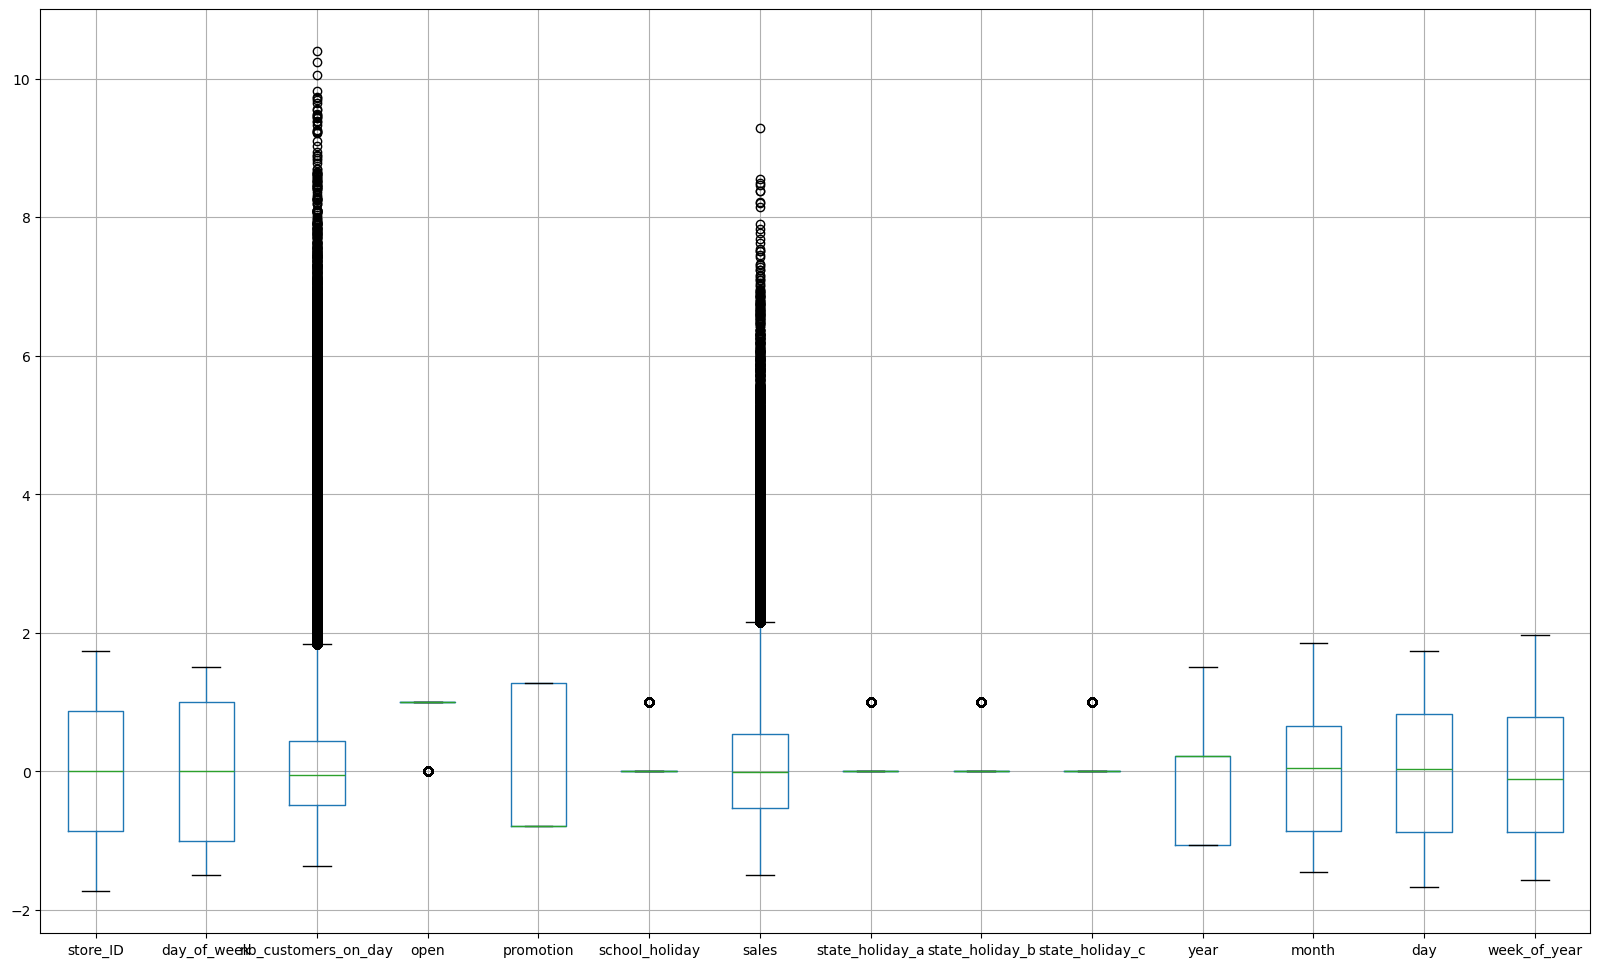

In [7]:
# Let's standardize the data and check boxplots to spot outliers
from sklearn.preprocessing import StandardScaler

def standardize_and_plot_data(dataset):
    
    # standardize dataset
    scaler = StandardScaler()
    dataset_stand = dataset.copy()
    numeric_columns = ['store_ID', 'day_of_week', 'nb_customers_on_day', 'promotion', 'year', 'month', 'day', 'sales', 'week_of_year']
    dataset_stand[numeric_columns] = scaler.fit_transform(dataset_stand[numeric_columns])
    
    # plot standardized dataset
    dataset_stand.boxplot(figsize=(20, 12))
    plt.show()
    
    return dataset_stand

sales_data_stand = standardize_and_plot_data(sales_data_cleaned)


Overall the dataset is pretty balanced with whiskers of even sizes around the boxes. However, we notice the presence of extreme outliers on these two features:

- **nb_customers_on_day**: Significant spread in the data. The presence of many outliers above the whiskers indicates that there are days with a much higher number of customers than usual. This feature has a large variance and potentially high skewness.

- **sales**: This feature has a significant number of high-value outliers, which suggests there are many days with exceptional sales values that differ from the majority. The median and IQR show a more typical range of sales, but the large number of outliers needs careful handling (e.g., capping or transformation).

In [8]:
# Removing outliers
def remove_outliers(dataset, max_score):

    # Calculate the Z-score for 'sales' and 'nb_customers_on_day'
    sales_z_scores = stats.zscore(dataset['sales'])
    customers_z_scores = stats.zscore(dataset['nb_customers_on_day'])

    # Step 2: Identify outliers (Z-score > max_score or Z-score < -max_score)
    outliers_sales = (abs(sales_z_scores) > max_score)
    outliers_customers = (abs(customers_z_scores) > max_score)

    # Step 3: Remove the outliers from the dataset (~ bitwise NOT operator) and return it
    dataset_no_outliers = dataset[~(outliers_sales | outliers_customers)]

    print(f'Removed {dataset.shape[0] - dataset_no_outliers.shape[0]} outliers.')
    
    return dataset_no_outliers

# remove outliers from unstandardized and standardized dataset
sales_data_no_outliers = remove_outliers(sales_data_cleaned, max_score=3)

Removed 10943 outliers.


In [9]:
# compare max outlier values before and after removing them
sales_data_cleaned.describe()

,store_ID,day_of_week,nb_customers_on_day,open,promotion,school_holiday,sales,state_holiday_a,state_holiday_b,state_holiday_c,year,month,day,week_of_year
count,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000
mean,558.211348,4.000189,633.398577,0.830185,0.381718,0.178472,5777.469011,0.020039,0.006576,0.004095,2013.832351,5.846555,15.711689,23.614139
std,321.878521,1.996478,464.094416,0.375470,0.485808,0.382910,3851.338083,0.140135,0.080824,0.063858,0.777335,3.326202,8.791182,14.433770
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,1.000000,1.000000,1.000000
25%,280.000000,2.000000,405.000000,1.000000,0.000000,0.000000,3731.000000,0.000000,0.000000,0.000000,2013.000000,3.000000,8.000000,11.000000
50%,558.000000,4.000000,609.000000,1.000000,0.000000,0.000000,5746.000000,0.000000,0.000000,0.000000,2014.000000,6.000000,16.000000,22.000000
75%,837.000000,6.000000,838.000000,1.000000,1.000000,0.000000,7860.000000,0.000000,0.000000,0.000000,2014.000000,8.000000,23.000000,35.000000
max,1115.000000,7.000000,5458.000000,1.000000,1.000000,1.000000,41551.000000,1.000000,1.000000,1.000000,2015.000000,12.000000,31.000000,52.000000


In [10]:
sales_data_no_outliers.describe()

,store_ID,day_of_week,nb_customers_on_day,open,promotion,school_holiday,sales,state_holiday_a,state_holiday_b,state_holiday_c,year,month,day,week_of_year
count,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000,629897.000000
mean,557.494357,4.011648,601.028432,0.827235,0.378549,0.177953,5576.019032,0.020262,0.006628,0.004142,2013.832593,5.836213,15.716281,23.567947
std,322.521339,1.995364,387.162991,0.378044,0.485026,0.382473,3517.447639,0.140895,0.081143,0.064225,0.777545,3.322176,8.784784,14.414666
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,1.000000,1.000000,1.000000
25%,279.000000,2.000000,399.000000,1.000000,0.000000,0.000000,3681.000000,0.000000,0.000000,0.000000,2013.000000,3.000000,8.000000,11.000000
50%,557.000000,4.000000,603.000000,1.000000,0.000000,0.000000,5685.000000,0.000000,0.000000,0.000000,2014.000000,6.000000,16.000000,22.000000
75%,838.000000,6.000000,823.000000,1.000000,1.000000,0.000000,7727.000000,0.000000,0.000000,0.000000,2014.000000,8.000000,23.000000,35.000000
max,1115.000000,7.000000,2025.000000,1.000000,1.000000,1.000000,17331.000000,1.000000,1.000000,1.000000,2015.000000,12.000000,31.000000,52.000000


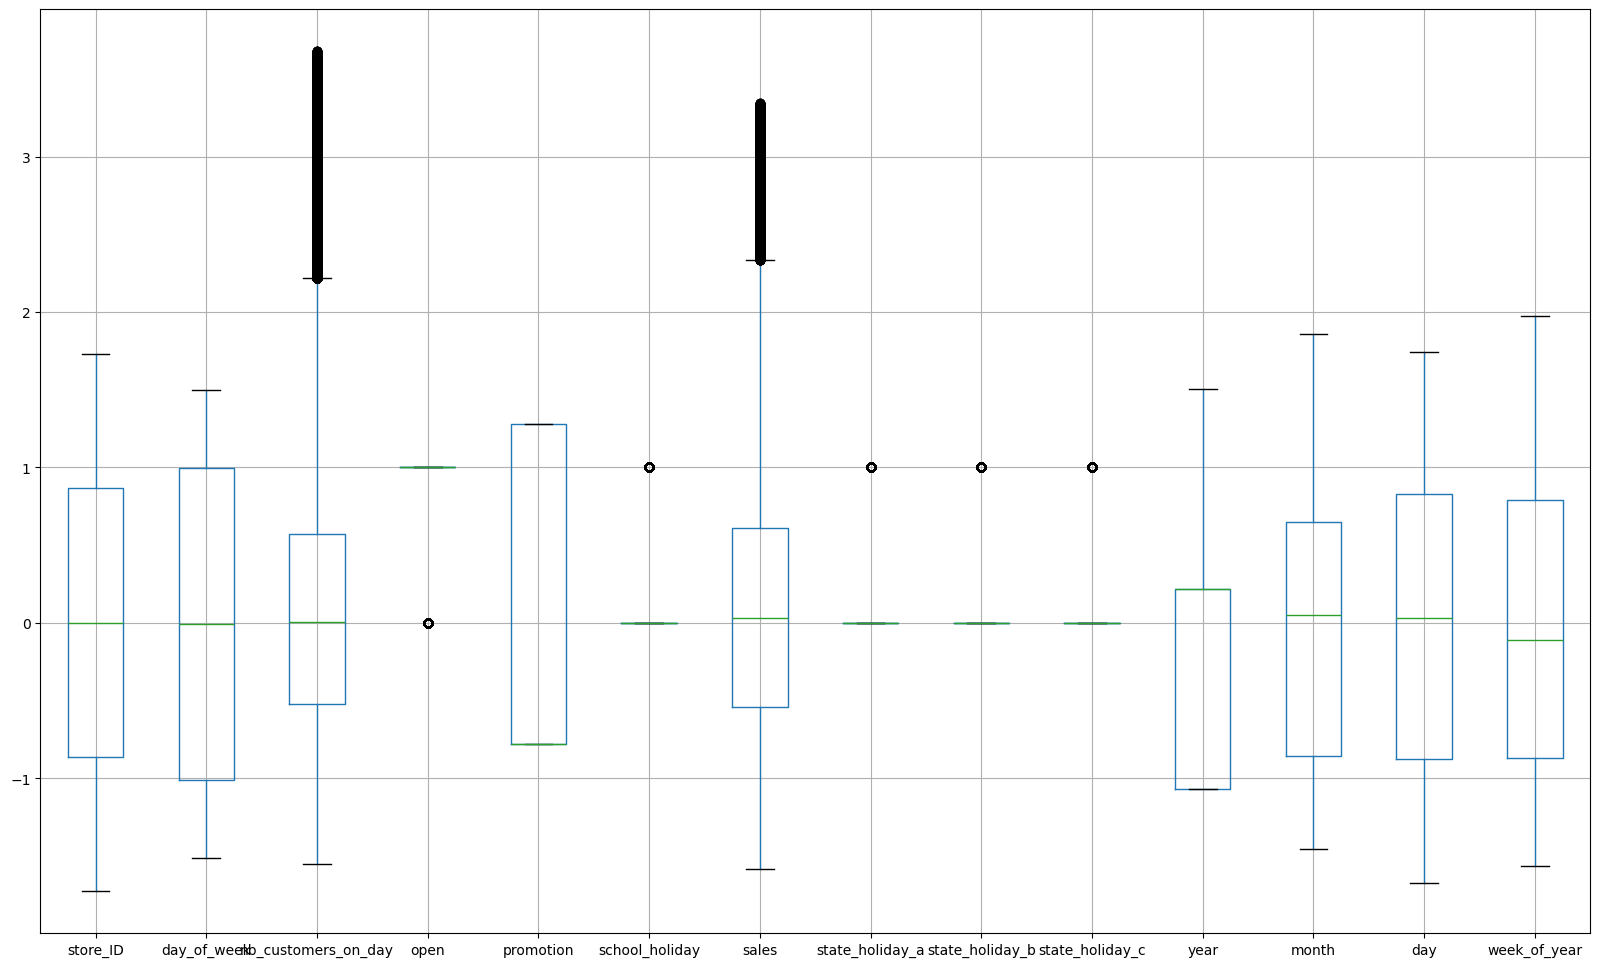

In [11]:
# let's visualise the new standardized datset
sales_data_no_outliers_stand = standardize_and_plot_data(sales_data_no_outliers)

The distribution looks much better, with outliers mostly grouped above the top whisker.

## Prepare Train and Test sets

In [12]:
from sklearn.model_selection import train_test_split

# Step 1: Define features (X) and target (y)
X = sales_data_no_outliers.drop(columns=['sales'])
y = sales_data_no_outliers['sales']

# Step 2: Perform an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the size of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((503917, 13), (125980, 13), (503917,), (125980,))

## Model 1: Linear Regression
Let's train a LinearRegression model with default parameters and calculate the r2 score

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Initialize the Linear Regression model
linear_model = LinearRegression()

# Step 2: Train the model on the training data
linear_model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = linear_model.predict(X_test)

# Step 4: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression\n{30*'-'}")
print("mse value:", mse)
print("r2 score: ", r2)


Linear Regression
------------------------------
mse value: 1673060.7451727511
r2 score:  0.8649088693573258


## Model 2: RandomForestRegressor
Let's do the same with a random forest regressor, with default parameters

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Initialize the Random Forest model
rf_model = RandomForestRegressor()

# Step 2: Train the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Step 4: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regressor\n{30*'-'}")
print("mse value:", mse)
print("r2 score: ", r2)


Random Forest Regressor
------------------------------
mse value: 693356.5130266178
r2 score:  0.9440149943428645


## Model 3: XBoost
Finally we want to train an XBoost model and compare its prediction results with the others.

In [15]:
from xgboost import XGBRegressor

# Step 1: Initialize the XBoost model
xgboost = XGBRegressor()

# Step 2: Train the XBoost model on the training data
xgboost.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = xgboost.predict(X_test)

# Step 4: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XBoost\n{30*'-'}")
print("mse value:", mse)
print("r2 score: ", r2)


XBoost
------------------------------
mse value: 905800.94150901
r2 score:  0.9268611891835308


## Hyperparameters Tuning
The RandomTreeRegressor seems to perform best on our dataset. Let's see if we can find the best combination of hyperparemeters to improve our r2 score using RandomizedSearchCV.

In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Step 1: Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Step 2: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(),
                                   param_distributions=param_grid,
                                   n_iter=10,  # Number of combinations to try
                                   cv=3,       # 3-fold cross-validation
                                   random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)  # This step is crucial

# Step 3: Retrieve the best hyperparameters and evaluate performance
best_rf_model = random_search.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)

# Step 4: Calculate MSE and R²
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

# Display the best parameters and model performance
print(f"RandomForestRegressor Optimized\n{50*'-'}")
print("Best Parameters: ", random_search.best_params_)
print("mse value:", mse_rf_tuned)
print("r2 score: ", r2_rf_tuned)


c:\Users\Nath\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



RandomForestRegressor Optimized
--------------------------------------------------
Best Parameters:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None}
mse value: 729972.5536589364
r2 score:  0.9410584356267808


## Delivery
Now that we have settled on a model and optimized the hyperparameters, we can predict on the real data and deliver our predicted labels.
- **Provided**: REAL_DATA.csv, validation set without the labels (sales column)
- **To deliver**: REAL_DATA.csv with added Sales column with our predictions

In [18]:
# Step 1: Load the real-life dataset 
real_data = pd.read_csv('REAL_DATA.csv')

# Step 2: Preprocess the data 
X_real = real_data.copy()
X_real['date'] = pd.to_datetime(X_real['date'], dayfirst=True)
X_real = pd.get_dummies(X_real, columns=['state_holiday'], drop_first=True)
X_real['year'] = X_real['date'].dt.year
X_real['month'] = X_real['date'].dt.month
X_real['day'] = X_real['date'].dt.day
X_real['week_of_year'] = X_real['date'].dt.isocalendar().week
X_real = X_real.drop(columns=['index', 'date'], axis=1)
print(X_real.info())

# Step 3: Predict sales using RandomTreeRegressor
predicted_sales = rf_model.predict(X_real)

# Step 4: Add predictions to the dataset
real_data['sales'] = predicted_sales

# Step 5: Save the dataset with predictions to a CSV file
real_data.to_csv('G1.csv', index=False)
print("Predictions saved to 'G1.csv'")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71205 entries, 0 to 71204
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   store_ID             71205 non-null  int64 
 1   day_of_week          71205 non-null  int64 
 2   nb_customers_on_day  71205 non-null  int64 
 3   open                 71205 non-null  int64 
 4   promotion            71205 non-null  int64 
 5   school_holiday       71205 non-null  int64 
 6   state_holiday_a      71205 non-null  bool  
 7   state_holiday_b      71205 non-null  bool  
 8   state_holiday_c      71205 non-null  bool  
 9   year                 71205 non-null  int32 
 10  month                71205 non-null  int32 
 11  day                  71205 non-null  int32 
 12  week_of_year         71205 non-null  UInt32
dtypes: UInt32(1), bool(3), int32(3), int64(6)
memory usage: 4.6 MB
None
Predictions saved to 'G1.csv'


## Extra Step: Calculate final score using the real labels
After delivering the project, we got access to the real labels. We can therefore calculate our final score ourselves.

In [19]:
real_data = pd.read_csv('G1.csv')
y_pred = real_data['sales']

real_data_labels = pd.read_csv('REAL_DATA_LABELS.csv')
y_true = real_data_labels['sales']

# Calculate final MSE and r2 score
mse_final = mean_squared_error(y_true, y_pred)
r2_final = r2_score(y_true, y_pred)

print(f"Final Scores\n{30*'-'}")
print("mse value:", mse_final)
print("r2 score: ", r2_final)

Final Scores
------------------------------
mse value: 1244284.0904165143
r2 score:  0.9160837104224522
